<a href="https://colab.research.google.com/github/CristinaMarsh/Learning_/blob/main/TStool/GluonTS_day3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gluonts
!pip install mxnet-cu101

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 8.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 360.0 MB 18 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


# Case 1: Thanks:
https://github.com/andrasfe/ethgas/blob/main/deepar_eth_gas.ipynb

In [2]:
!pip install ujson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 2.7 MB/s 


In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import shutil
from datetime import datetime
from datetime import timedelta
# !pip uninstall pystan -y
# !pip install pystan~=2.14
# !pip install fbprophet
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
from numpy import mean
from numpy import std
# !pip install mxnet gluonts ujson
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution import ZeroInflatedNegativeBinomialOutput, StudentTOutput #likelihood
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean

from gluonts.evaluation import Evaluator
from gluonts.model.predictor import Predictor
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from datetime import datetime, date, time
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

In [4]:
def prepare_crypto_df(file_name):
    crypto_price_df = pd.read_csv(file_name, header=0, index_col=1)
    crypto_price_df = crypto_price_df[['close']]
    crypto_price_df.index.names = ['Date']
    crypto_price_df.columns = ['Count']
    return crypto_price_df

In [11]:
!git clone https://github.com/andrasfe/ethgas.git

Cloning into 'ethgas'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 53 (delta 0), reused 2 (delta 0), pack-reused 50
Unpacking objects: 100% (53/53), done.


In [12]:
! unzip "/content/ethgas/data.zip" -d "/content/"

Archive:  /content/ethgas/data.zip
  inflating: /content/Binance_ETHUSDT_minute.csv  
  inflating: /content/Binance_MATICUSDT_minute.csv  
  inflating: /content/blocks.csv     
  inflating: /content/logs.csv       
  inflating: /content/token_transfers.csv  
  inflating: /content/traces.csv     
  inflating: /content/transactions.csv  


In [32]:
#loading data 
transactions = pd.read_csv('transactions.csv', header=0, index_col=0)
deep_ds = transactions.drop(['Value'], axis=1)
transaction_values = transactions.drop(['Price'], axis=1)
transaction_values.columns = ['Count']
ethprice = prepare_crypto_df('Binance_ETHUSDT_minute.csv')
maticprice = prepare_crypto_df('Binance_MATICUSDT_minute.csv')

In [60]:
# features
features = []
names = []
features.append(ethprice)
names.append('ethprice')
# features.append(maticprice)
# names.append('maticprice')
features.append(transaction_values)
names.append('transaction_values')
features.append(pd.read_csv('blocks.csv', header=0, index_col=0))
names.append('blocks')
features.append(pd.read_csv('token_transfers.csv', header=0, index_col=0))
names.append('token_transfers')
features.append(pd.read_csv('traces.csv', header=0, index_col=0))
names.append('traces')
features.append(pd.read_csv('logs.csv', header=0, index_col=0))
names.append('logs')

In [ ]:
#!unzip -o data.zip

In [52]:
def normalize_df(df):
  return (df - df.min()) / (df.max() - df.min())

In [17]:
ENABLE_FEATURES = True
RUN_MODEL = False
DELTA = 40
AGG = 20
FREQ = str(AGG) + 'min'

In [19]:
deep_ds.head()

,Price
Date,
2021-01-01 00:00:00,7.363430e+10
2021-01-01 00:01:00,6.615670e+10
2021-01-01 00:02:00,6.704984e+10
2021-01-01 00:03:00,7.918360e+10
2021-01-01 00:04:00,8.656393e+10


In [34]:
#in order
deep_ds = deep_ds.sort_index()
deep_ds.index = pd.to_datetime(deep_ds.index)

deep_ds = deep_ds.groupby(pd.Grouper(level='Date', freq=FREQ)).mean()
end = deep_ds.index[-1]
deep_ds.head()

,Price
Date,
2021-01-01 00:00:00,8.084088e+10
2021-01-01 00:20:00,8.024579e+10
2021-01-01 00:40:00,7.701433e+10
2021-01-01 01:00:00,8.713914e+10
2021-01-01 01:20:00,7.425917e+10


In [35]:
test_cnt = int(0.2*deep_ds.shape[0])
test_start = deep_ds.shape[0] - test_cnt
train_ds = deep_ds[:deep_ds.index[test_start]]

In [39]:
DELTA*AGG

800

In [40]:
start = deep_ds.index[deep_ds.shape[0]-test_cnt+1]
end = deep_ds.index[-1] - timedelta(minutes=DELTA*AGG)
test_ds = deep_ds[deep_ds.index[deep_ds.shape[0] - test_cnt + 1]:end]

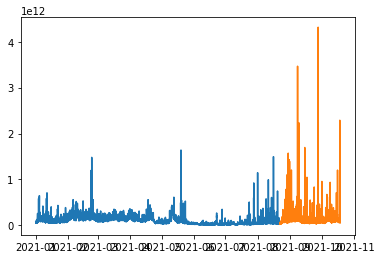

In [46]:
plt.plot(train_ds)
plt.plot(test_ds)

In [61]:
train_features = []
test_features = []

def fill_feature(reference_ds, feature):
    for date_entry in reference_ds.index:
        if not date_entry in feature.index:
            feature.loc[date_entry] = 0

In [54]:
len(features)

6

In [62]:
#is a list
for i in range(len(features)):
    features[i]=features[i].sort_index()
    features[i].index = pd.to_datetime(features[i].index)
    features[i] = features[i][deep_ds.index[0]:deep_ds.index[-1]]
    if features[i].shape[0] != deep_ds.shape[0]:
        fill_feature(deep_ds, features[i])

    features[i] = features[i].groupby(pd.Grouper(level='Date', freq=FREQ)).mean()
    features[i] = features[i]["Count"]
    features[i] = normalize_df(features[i])
    train_features.append(features[i][:deep_ds.index[test_start]])
    test_features.append(features[i][features[i].index[deep_ds.shape[0] - test_cnt + 1]:end])   

In [75]:
features

[Date
 2021-01-01 00:00:00    0.168706
 2021-01-01 00:20:00    0.168250
 2021-01-01 00:40:00    0.168709
 2021-01-01 01:00:00    0.169715
 2021-01-01 01:20:00    0.170718
                          ...   
 2021-10-18 22:20:00    0.855756
 2021-10-18 22:40:00    0.858030
 2021-10-18 23:00:00    0.860523
 2021-10-18 23:20:00    0.861392
 2021-10-18 23:40:00    0.861845
 Freq: 20T, Name: Count, Length: 20952, dtype: float64, Date
 2021-01-01 00:00:00    0.033890
 2021-01-01 00:20:00    0.033887
 2021-01-01 00:40:00    0.010879
 2021-01-01 01:00:00    0.035850
 2021-01-01 01:20:00    0.013808
                          ...   
 2021-10-18 22:20:00    0.013703
 2021-10-18 22:40:00    0.006846
 2021-10-18 23:00:00    0.010218
 2021-10-18 23:20:00    0.021640
 2021-10-18 23:40:00    0.219369
 Freq: 20T, Name: Count, Length: 20952, dtype: float64, Date
 2021-01-01 00:00:00    0.224125
 2021-01-01 00:20:00    0.182474
 2021-01-01 00:40:00    0.197672
 2021-01-01 01:00:00    0.207709
 2021-01-01 01

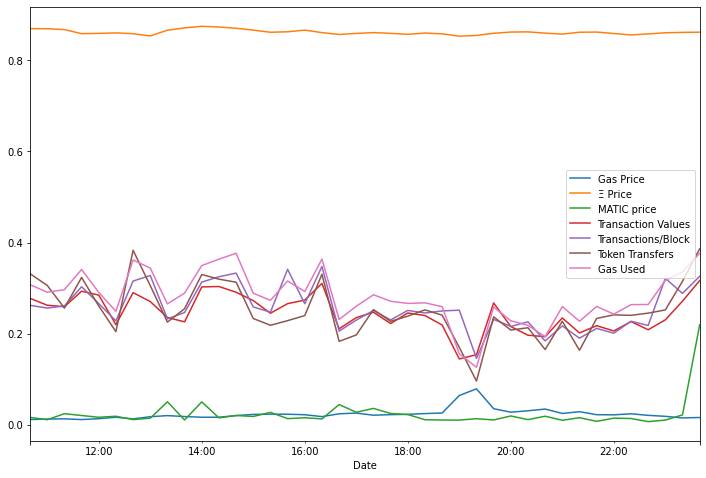

In [63]:
RANGE = DELTA
column_names = ['Gas Price', 'Ξ Price', 'MATIC price', 'Transaction Values', 'Transactions/Block', 'Token Transfers', 'Gas Used']
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ns = normalize_df(deep_ds)
correlation_df = pd.DataFrame(ns[-RANGE:])
correlation_df.columns = [column_names[0]]
ns[-RANGE:].plot(ax=ax)
for i in range(len(features)):
    features[i][-RANGE:].plot(ax=ax)
    correlation_df[column_names[i + 1]] = features[i][-RANGE:]

# fig.suptitle('Normalized Feature Values', fontsize=20)

plt.legend(column_names, loc="best", prop={'size': 10})
plt.show()

In [64]:
df_corr = correlation_df.corr()
df_corr.to_latex('corr.tex', float_format='%.2f')
df_corr

,Gas Price,Ξ Price,MATIC price,Transaction Values,Transactions/Block,Token Transfers,Gas Used
Gas Price,1.000000,-0.441298,-0.143281,-0.708723,-0.516904,-0.708408,-0.773658
Ξ Price,-0.441298,1.000000,0.081790,0.485708,0.325694,0.394839,0.461708
MATIC price,-0.143281,0.081790,1.000000,0.320767,0.224258,0.342344,0.290561
Transaction Values,-0.708723,0.485708,0.320767,1.000000,0.792918,0.855414,0.924041
Transactions/Block,-0.516904,0.325694,0.224258,0.792918,1.000000,0.792345,0.881172
Token Transfers,-0.708408,0.394839,0.342344,0.855414,0.792345,1.000000,0.910394
Gas Used,-0.773658,0.461708,0.290561,0.924041,0.881172,0.910394,1.000000


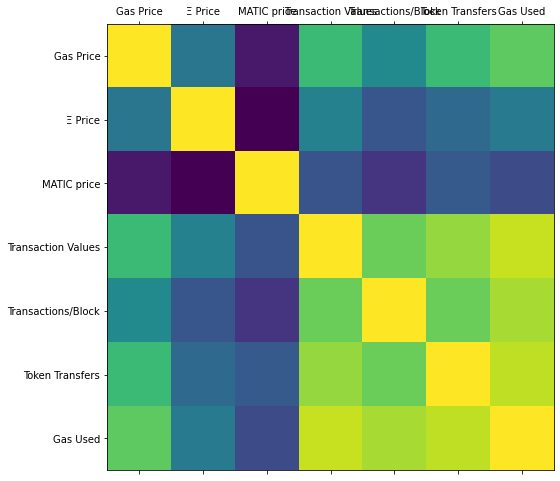

In [68]:
plt.figure(figsize=(8,8))
plt.matshow(df_corr.abs(), fignum=1)
ax = plt.gca()
ax.set_xticklabels([column_names] + column_names)
ax.set_yticklabels([column_names] + column_names)
plt.show()

# Model training

In [69]:
dyn_features = [feature for feature in train_features]

training_data = ListDataset(
    [
     {'start':deep_ds.index[0],
      'target':train_ds['Price'],
      'feat_dynamic_real':dyn_features}
    ],freq=FREQ
)

In [71]:

feature_cnt = len(features) if ENABLE_FEATURES else 0 
feature_cnt

6

In [81]:
import mxnet as mx
model_path = "./pred_{}_{}_{}/".format(DELTA, AGG, feature_cnt)
RUN_MODEL = True
if RUN_MODEL:
    callbacks = [
        LearningRateReduction(objective="min",
                            patience=10,
                            base_lr=5e-3,
                            decay_factor=0.5,
                            ),
        ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
    ]

    estimator = DeepAREstimator(
        freq=FREQ,      
        prediction_length=DELTA,
        context_length=2*DELTA,
        num_layers = 4,
        num_cells = 40,
        use_feat_dynamic_real = ENABLE_FEATURES,
        cell_type='gru',
        distr_output=StudentTOutput(),
        dropout_rate=0.01,
        trainer=Trainer(ctx = mx.context.gpu(),
                        epochs=200,
                        callbacks=callbacks))

    predictor = estimator.train(training_data)
    if os.path.exists(model_path):
        shutil.rmtree(model_path)
    os.mkdir( model_path)
    predictor.serialize(Path(model_path))
else:
    predictor = Predictor.deserialize(Path(model_path))

100%|██████████| 50/50 [00:26<00:00,  1.89it/s, epoch=91/200, avg_epoch_loss=24.3]


Early stopping based on learning rate scheduler callback (min_lr was reached).


## Make prediction

In [83]:
end_date = datetime.combine(date(2021,10,17), time(6,0))
start_date = end_date - timedelta(10*AGG*DELTA) 
test_ds = test_ds[start_date:end_date]['Price']
dyn_features = [feature[start_date:end_date] for feature in test_features]

In [88]:
test_data = ListDataset(
    [{"start": test_ds.index[0], "target": test_ds
    ,'feat_dynamic_real': dyn_features
    }],
    freq = FREQ
)

In [89]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

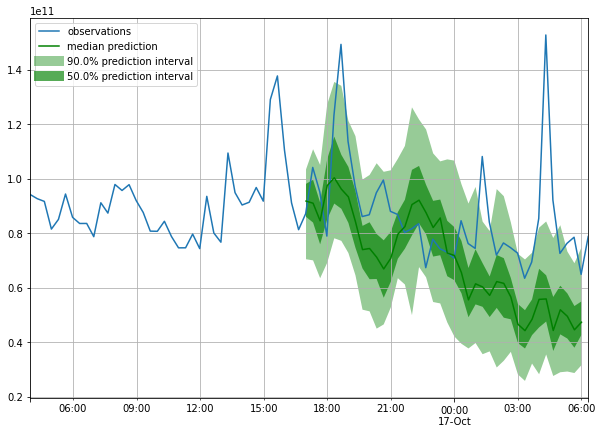

In [90]:
image_file = "pred_{}_{}_{}_{}.jpg".format(end_date, DELTA, AGG, feature_cnt)

def plot_prob_forecasts(ts_entry, forecast_entry, image_file):
    plot_length = 80
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.savefig(image_file, dpi=150, bbox_inches='tight')
    plt.show()
    

plot_prob_forecasts(tss[0], forecasts[0], image_file)

In [91]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9], ignore_invalid_values=True)
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=1)

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


In [94]:
agg_metrics

{'Coverage[0.1]': 0.025,
 'Coverage[0.5]': 0.2,
 'Coverage[0.9]': 0.6,
 'MAE_Coverage': 0.225,
 'MAPE': 0.2222731351852417,
 'MASE': 0.4159177991574732,
 'MSE': 6.405842422878221e+20,
 'MSIS': 2.9593906586762304,
 'ND': 0.23091431905456009,
 'NRMSE': 0.2916114020303922,
 'OWA': nan,
 'QuantileLoss[0.1]': 279378350080.0,
 'QuantileLoss[0.5]': 801667883008.0,
 'QuantileLoss[0.9]': 484502927769.6,
 'RMSE': 25309765749.366825,
 'abs_error': 801667874816.0,
 'abs_target_mean': 86792785100.8,
 'abs_target_sum': 3471711404032.0,
 'mean_absolute_QuantileLoss': 521849720285.8667,
 'mean_wQuantileLoss': 0.15031483310502056,
 'sMAPE': 0.2598167896270752,
 'seasonal_error': 48186677538.20243,
 'wQuantileLoss[0.1]': 0.08047280363095091,
 'wQuantileLoss[0.5]': 0.23091432141420323,
 'wQuantileLoss[0.9]': 0.13955737426990752}

In [92]:
csv_file = "pred_{}_{}_{}_{}.json".format(end_date, DELTA, AGG, feature_cnt)
with open(csv_file, 'w') as writer:
    writer.write(json.dumps(agg_metrics, indent=4))

In [93]:
print('Last run:', image_file, csv_file)

Last run: pred_2021-10-17 06:00:00_40_20_6.jpg pred_2021-10-17 06:00:00_40_20_6.json


In [ ]:
te

In [29]:
deep_ds.resample(freq='M')

AttributeError: ignored